/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
[I 2025-02-07 10:18:54,170] A new study created in memory with name: no-name-eb8504d3-c3b2-4adf-8ed2-40fea207656f
[I 2025-02-07 10:19:28,973] Trial 0 finished with value: 0.9766072555530348 and parameters: {'rf_n_estimators': 87, 'rf_max_depth': 7, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 3, 'lgb_n_estimators': 75, 'lgb_learning_rate': 0.025409967693229958, 'lgb_max_depth': 4}. Best is trial 0 with value: 0.9766072555530348.
[I 2025-02-07 10:22:26,835] Trial 1 finished with value: 0.9739343994295121 and parameters: {'rf_n_estimators': 89, 'rf_max_depth': 6, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 2, 'lgb_n_estimators': 82, 'lgb_learning_rate': 0.020920998122386684, 'lgb_max_depth': 5}. Best is trial 0 with value: 0.9766072555530348.
[I 2025-02-07 10:24:59,199] Trial 2 finished with value: 0.9790043843173944 and para

Best Parameters: {'rf_n_estimators': 86, 'rf_max_depth': 10, 'rf_min_samples_split': 5, 'rf_min_samples_leaf': 1, 'lgb_n_estimators': 124, 'lgb_learning_rate': 0.03241393644350424, 'lgb_max_depth': 3}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 2
[LightGBM] [Info] Start training from score 44.803262
Cross-Validation R² Mean: 0.9932
Optimized Stacking Model R²: 0.9954
Mean Absolute Error (MAE): 0.7566
Root Mean Squared Error (RMSE): 1.0803


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


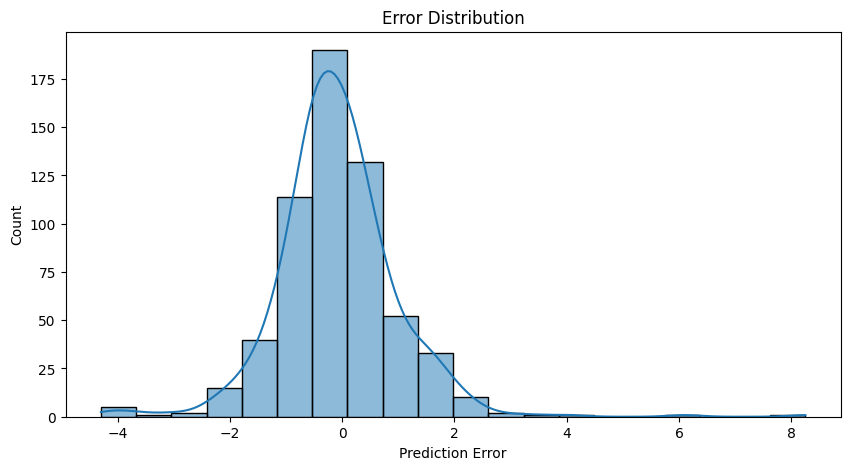

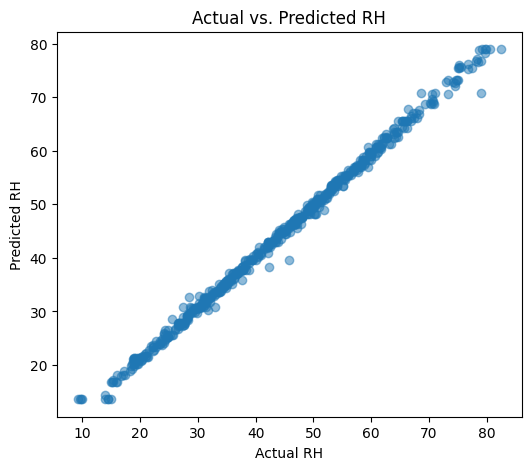

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from lightgbm import LGBMRegressor  # ✅ Faster boosting model
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# ✅ Load Dataset
file_path = "/kaggle/input/air-quality-data-set/AirQuality.csv"
data = pd.read_csv(file_path, sep=";", decimal=",", low_memory=False)

# ✅ Drop irrelevant columns
columns_to_drop = ['Unnamed: 15', 'Unnamed: 16']
data.drop(columns=[col for col in columns_to_drop if col in data.columns], inplace=True)

# ✅ Convert Date & Time
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y', errors='coerce')
data['Time'] = data['Time'].str.replace(".", ":", regex=False)
data['Hour'] = pd.to_datetime(data['Time'], format='%H:%M:%S', errors='coerce').dt.hour
data.drop(columns=['Time', 'Date'], inplace=True)

# ✅ Handle Missing Values
data.replace(-200, np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

# ✅ Remove Highly Correlated Features (Correlation > 0.9)
corr_matrix = data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
data.drop(columns=to_drop, inplace=True)

# ✅ Define Target & Features
y = data["RH"]
X = data.drop(columns=["RH"])

# ✅ Normalize Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Reduce Data Size for Speed
X_scaled, y = X_scaled[:3000], y[:3000]  # ✅ Use 30% of data

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# ✅ Hyperparameter Optimization
def objective(trial):
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 50, 100)  # ✅ Reduce max trees
    rf_max_depth = trial.suggest_int('rf_max_depth', 4, 10)  # ✅ Reduce depth
    rf_min_samples_split = trial.suggest_int('rf_min_samples_split', 2, 6)
    rf_min_samples_leaf = trial.suggest_int('rf_min_samples_leaf', 1, 3)

    lgb_n_estimators = trial.suggest_int('lgb_n_estimators', 50, 150)  # ✅ Use LGBM
    lgb_learning_rate = trial.suggest_float('lgb_learning_rate', 0.01, 0.1, log=True)
    lgb_max_depth = trial.suggest_int('lgb_max_depth', 3, 7)

    rf = RandomForestRegressor(
        n_estimators=rf_n_estimators, max_depth=rf_max_depth,
        min_samples_split=rf_min_samples_split, min_samples_leaf=rf_min_samples_leaf,
        n_jobs=-1, random_state=42
    )

    lgb = LGBMRegressor(
        n_estimators=lgb_n_estimators, learning_rate=lgb_learning_rate,
        max_depth=lgb_max_depth, n_jobs=-1, random_state=42
    )

    stacking = StackingRegressor(
        estimators=[('rf', rf), ('lgb', lgb)],
        final_estimator=LGBMRegressor(n_estimators=20, random_state=42)  # ✅ Reduce estimators
    )

    kf = KFold(n_splits=3, shuffle=True, random_state=42)  # ✅ Reduce folds
    cv_r2 = cross_val_score(stacking, X_train, y_train, scoring="r2", cv=kf, n_jobs=-1).mean()
    return cv_r2

# ✅ Run Optuna (Reduced trials)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # ✅ Reduce trials

# ✅ Best Parameters
best_params = study.best_params
print(f"Best Parameters: {best_params}")

# ✅ Train Final Optimized Stacking Model
optimized_rf = RandomForestRegressor(
    n_estimators=best_params['rf_n_estimators'], max_depth=best_params['rf_max_depth'],
    min_samples_split=best_params['rf_min_samples_split'], min_samples_leaf=best_params['rf_min_samples_leaf'],
    n_jobs=-1, random_state=42
)

optimized_lgb = LGBMRegressor(
    n_estimators=best_params['lgb_n_estimators'], learning_rate=best_params['lgb_learning_rate'],
    max_depth=best_params['lgb_max_depth'], n_jobs=-1, random_state=42
)

final_meta_model = LGBMRegressor(n_estimators=30, random_state=42)  # ✅ Reduce meta-model trees

final_stacking_model = StackingRegressor(estimators=[
    ('rf', optimized_rf),
    ('lgb', optimized_lgb)
], final_estimator=final_meta_model, n_jobs=-1)

# ✅ Cross-Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(final_stacking_model, X_train, y_train, scoring='r2', cv=kf, n_jobs=-1)

# ✅ Train Final Model
final_stacking_model.fit(X_train, y_train)
y_pred_final = final_stacking_model.predict(X_test)

# ✅ Evaluate Model
r2 = r2_score(y_test, y_pred_final)
mae = mean_absolute_error(y_test, y_pred_final)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))

print(f"Cross-Validation R² Mean: {cv_r2_scores.mean():.4f}")
print(f"Optimized Stacking Model R²: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# ✅ Visualizations
plt.figure(figsize=(10, 5))
sns.histplot(y_test - y_pred_final, bins=20, kde=True)
plt.xlabel("Prediction Error")
plt.title("Error Distribution")
plt.show()

plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_final, alpha=0.5)
plt.xlabel("Actual RH")
plt.ylabel("Predicted RH")
plt.title("Actual vs. Predicted RH")
plt.show()
